<a href="https://colab.research.google.com/github/cjpdrury/evidence_networks/blob/fluxes/evidence_network_galaxy_properties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evidence Network example on galaxy properties
Charlie Drury and Niall Jeffrey, UCL

09/11/2023

The following notebook demonstrates use of an evidence network to derive Bayes factors. The data consists of simulated galaxy properties derived from two models; Illustris TNG (model $M_0$) and Simba (model $M_1$). The network is trained on a subset of labelled TNG and Simba data. The trained network is then used on test data to calculate Bayes factors for each galaxy.

The evidence network accuracy is assessed using a coverage test. It's performance is compared to a density estimation method using PZFlow.

This notebook is a preceeds evidence_network_galaxy_photometries.ipynb.

Further details of techniques used in this notebook are available from "Evidence Networks: simple losses for fast, amortized, neural
Bayesian model comparison" by Niall Jeffrey and Benjamin D. Wandelt (2023). Available at: https://arxiv.org/abs/2305.11241.

In [ ]:
# install this version of tf to use decayed lr metric
!pip install tensorflow==2.8.0
!pip install pzflow matplotlib



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [ ]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import numpy as np
from scipy.stats import norm, multivariate_normal
import sys, os, time, gc

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LeakyReLU, Input,ReLU
from tensorflow.keras import optimizers, callbacks

from tensorflow.keras.layers import concatenate, BatchNormalization

import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import requests
import time

from pzflow import Flow
from pzflow.examples import get_twomoons_data

import jax.numpy as jnp
from mpl_toolkits.mplot3d import Axes3D


import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'
plt.rcParams["figure.facecolor"] = "white"
print(tf.config.list_physical_devices('GPU'))
tf.print(tf.constant([0.0]))
print(tf.__version__)

[]
[0]
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# !cd /content/drive/MyDrive/ML_Intern/

path = '/content/drive/MyDrive/ML_Intern'



Mounted at /content/drive


## Import Data and Save as Numpy file
Once the Numpy file is created it is not necessary to run this each time

In [ ]:
# import and save data as npy file
train_Illu = np.loadtxt(path+"/galaxies_IllustrisTNG_z=0.00.txt", float)
train_SIMB = np.loadtxt(path+"/galaxies_SIMBA_z=0.00.txt", float)

f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()

np.save(path+'/gal_Illu.npy',train_Illu)
np.save(path+'/gal_SIMB.npy',train_SIMB)


In [ ]:
f = open(path+"/galaxies_IllustrisTNG_z=0.00.txt")
header = f.readline()
header = header.split('|')
print(header[0:10])
# gal_Illu

['# ', ' gas mass ', ' stellar mass ', ' black-hole mass ', ' total mass ', ' Vmax ', ' velocity dispersion ', ' gas metallicity ', ' stars metallicity ', ' star-formation rate ']


## Load and prepare data
Each data file contains >100,000 data vectors. Note that SIMBA is about a 1.6x larger dataset than IllustrisTNG. A data vector is a package of 17 properties for a given galaxy. The values are normalised as they range over several orders of magnitude. A dataframe for each model is made to examine the data, but the numpy array is fed into the network as this is faster. <br>
The models are assigned the labels; SIMBA (1), IllustrisTNG (0). They are combined into one set of training data. x_train is the data and y_train is the labels.


In [ ]:
# unpack data
train_Illu = np.load(path+'/gal_Illu.npy')
train_SIMB = np.load(path+'/gal_SIMB.npy')
print(np.shape(train_Illu))

# get headers and convert to pandas
header = 'gas mass | stellar mass | black-hole mass | total mass | Vmax | velocity dispersion | gas metallicity | stars metallicity | star-formation rate | spin | peculiar velocity | stellar radius | total radius | Vmax radius | U | K | g'
header = header.split('|')

df_Illu = pd.DataFrame(train_Illu, columns=header)
df_SIMB = pd.DataFrame(train_SIMB, columns=header)

# add model labels 'm'
df_Illu['m'] = np.zeros(df_Illu.shape[0])
df_SIMB['m'] = np.ones(df_SIMB.shape[0])



(720548, 17)


In [ ]:
df_gal = df_Illu.append(df_SIMB)
df_gal.head()
# df_gal.iloc[0:5,0:5]

<ipython-input-6-bbc7c8626d90>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_gal = df_Illu.append(df_SIMB)


,gas mass,stellar mass,black-hole mass,total mass,Vmax,velocity dispersion,gas metallicity,stars metallicity,star-formation rate,spin,peculiar velocity,stellar radius,total radius,Vmax radius,U,K,g,m
0,9.282650e+12,5.420345e+11,1.466206e+09,6.418189e+13,728.5484,388.82180,0.004787,0.017947,9.441491,7318.4480,33.48256,0.021288,0.265175,0.195745,-22.93387,-26.54785,-23.42693,0.0
1,1.038497e+11,2.636133e+10,1.044907e+07,9.836553e+11,233.9234,119.81900,0.018286,0.015760,2.637218,1866.9370,514.23650,0.005122,0.044712,0.015302,-21.15315,-23.88854,-21.25109,0.0
2,9.195971e+08,2.106634e+10,1.157354e+08,3.509456e+11,208.0617,99.18353,0.009185,0.015279,0.000000,129.6710,469.85760,0.003984,0.025255,0.004423,-19.08513,-23.24341,-19.95050,0.0
3,3.779673e+10,1.197717e+09,1.650660e+06,2.944225e+11,155.9398,88.05768,0.002823,0.003315,0.186221,1364.7460,903.87620,0.007515,0.026186,0.027755,-18.45237,-20.64906,-18.61216,0.0
4,6.460591e+09,9.020908e+09,3.054039e+06,1.818515e+11,150.3801,76.50587,0.016340,0.010027,0.260545,115.4676,318.39040,0.005950,0.019798,0.007311,-19.32953,-22.77941,-19.95593,0.0


In [ ]:
# assign label of 0 for IllustrisTNG and 1 for SIMBA
train_Illu = np.append(train_Illu, np.zeros((len(train_Illu[:,0]),1)) ,axis=1)
train_SIMB = np.append(train_SIMB, np.ones((len(train_SIMB[:,0]),1)) ,axis=1)



In [ ]:
# combine into one dataset :- use equal priors to test flow
train_data = np.append(train_SIMB,train_Illu, axis=0 )


# below is for using stellar mass and stellar metallicity
train_data = train_data[:,[1,7,-1]]

print(train_data[:,:-1].shape)


(1902813, 2)


In the following we select a sub-sample of the data to speed up training. The dataset is then split into training and testing in an 80:20 split.


In [ ]:
# randomly sample from training data

# n_sample = 500000
n_sample = train_data.shape[0]

choices = np.random.choice(train_data.shape[0],
                                  size=n_sample,
                                  replace=False)
train_data = train_data[choices,:]
print(train_data.shape)


# separate training, validation and test data
x_train, x_test, y_train, y_test = train_test_split(train_data[:,:-1], train_data[:,-1], test_size=0.20, shuffle=True, random_state=44)
x_train, x_val, y_train, y_val = train_test_split(x_train[:,:], y_train[:], test_size=0.20, shuffle=True, random_state=43)


(1902813, 3)


In [ ]:
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape,y_test.shape )

(1217800, 2) (304450, 2) (380563, 2) (1217800,) (304450,) (380563,)


In [ ]:
# check the fraction of each model is the same in each set
print(np.mean(y_train), np.mean(y_val),np.mean(y_test) )

0.6211906717030711 0.6223846280177369 0.620906393947914


## Scale data and view distributions

In [ ]:
# normalise each set of data:- note this is specific to stellar mass and metallicity

x_train_scaled = np.copy(x_train)
x_train_scaled[:,0] = np.log(x_train_scaled[:,0])
scaler = StandardScaler()
scaler.fit(x_train_scaled)
x_train_scaled = scaler.transform(x_train_scaled)/20.+0.5

def data_scaler(data):
    """
    Scales input testing and validation data
    """

    data_scaled = np.copy(data)
    data_scaled[:,0] = np.log(data[:,0])
    data_scaled = scaler.transform(data_scaled)/20.+0.5

    return data_scaled

x_test_scaled = data_scaler(x_test)
x_val_scaled = data_scaler(x_val)


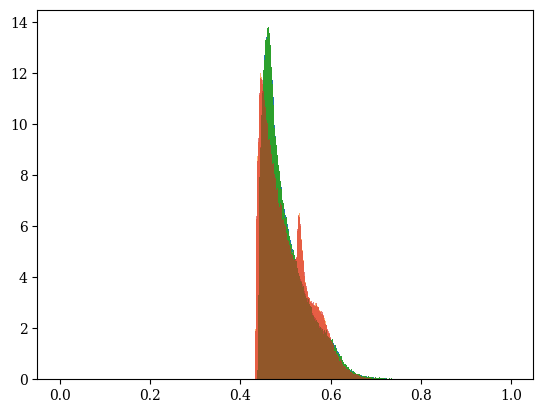

In [ ]:
# check distributions match
_ = plt.hist(x_train_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_train_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

_ = plt.hist(x_val_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
_ = plt.hist(x_val_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

# _ = plt.hist(x_test_scaled[:,1],bins=np.linspace(-0,1,512),density=True)
# _ = plt.hist(x_test_scaled[:,0],bins=np.linspace(-0,1,512),alpha=0.6,density=True)

In [ ]:
# view distributions of all data

# plt.figure(figsize=(10,18))
# for i in range(17):
#     plt.subplot(6,3,i+1)
#     plt.grid(False)
#     _ = plt.hist(x_train_scaled[:,i],bins=np.linspace(-5,5,512),density=True)
#     plt.title(str(header[i]))

# plt.subplots_adjust(hspace=.2)


This cell finds the ratio of samples from each model.

In [ ]:
def M_ratio(y):
  scale = np.sum(y)/np.sum(1 - y)
  return scale

print(M_ratio(y_train), M_ratio(y_val), M_ratio(y_test))




1.6398505139666257 1.648197277432262 1.6378709216810263


## Define functions for network

In [ ]:
def smooth_sign(x, k =100.):

    return 2.*tf.math.sigmoid(k*x) - 1


def parity_odd_power(x, alpha=2):
    return (x)*(tf.math.abs(x)**(alpha-1))


# def leaky_parity_odd_power(x, alpha=2):
#     x_transition = (alpha)**(alpha/(1.-alpha))
#     shift=(alpha)**(1./(1.-alpha)) - x_transition
#     return tf.where(tf.math.abs(x)<x_transition, x, tf.sign(x)*tf.math.abs(x+tf.sign(x)*shift)**alpha)


def leaky_parity_odd_power(x, alpha=2):
    return x + parity_odd_power(x, alpha)

In [ ]:
# Evidence Net functions:

class POPExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred =  leaky_parity_odd_power(model_pred, alpha=1)
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


class ExpLoss(tf.keras.losses.Loss):
    """
    Custom exponential loss
    """

    def call(self, model_label, model_pred):
        model_pred = tf.clip_by_value(model_pred, -50, 50)
        loss_val =  tf.math.exp((0.5 - model_label) * (model_pred) )
        return tf.reduce_mean(loss_val)


def get_lr_metric(optimizer):
    """
    Learning rate on-the-fly
    :param optimizer:
    :return: learning rate
    """
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)  # I use ._decayed_lr method instead of .lr
        # return optimizer.lr(tf.float32) #C try .lr
    return lr



class DenseNetwork:
    """
    Network that takes in data and returns functions of the Bayesian evidence
    """

    def __init__(self, input_size, weight_init='he_normal', layer_width=100, added_layers=3,
                 learning_rate=1e-4, decay_rate=None, batch_norm_flag=1, residual_flag=0):
        """
        Initialisation
        :param map_size: size of square image (there are map_size**2 pixels)
        :param learning_rate: learning rate for the optimizer
        """
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.layer_width = layer_width
        self.weight_init = weight_init
        self.decay_rate = decay_rate
        self.added_layers = added_layers
        self.batch_norm_flag = batch_norm_flag
        self.residual_flag = residual_flag


        print('Hyper-parameters:', input_size, weight_init, layer_width, added_layers,
              learning_rate, decay_rate, batch_norm_flag, residual_flag)

    def simple_layer(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)
        return x_out

    def residual_block(self, x_in):
        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_in)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        # x_out = tf.tanh(x_out)
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_out)
        x_out = LeakyReLU(alpha=0.1)(x_out) + x_in
        if self.batch_norm_flag == 1:
            x_out = BatchNormalization()(x_out)

        return x_out

    def model(self):

        input_data = (Input(shape=(self.input_size,)))


        x1 = Dense(int(1.1*self.input_size)+20, input_dim=self.input_size, kernel_initializer=self.weight_init)(input_data)
        x_inner = LeakyReLU(alpha=0.1)(x1)
        x_inner = BatchNormalization()(x_inner)
        x_inner = Dense(self.layer_width, input_dim=self.input_size, kernel_initializer=self.weight_init)(x_inner)
        x_inner = LeakyReLU(alpha=0.1)(x_inner)
        x_inner = BatchNormalization()(x_inner)

        # x_inner = tf.tanh(x1)

        for i in range(self.added_layers):
            x_inner = self.residual_block(x_inner)
            # x_inner = self.simple_layer(x_inner)

        x_out = Dense(self.layer_width, kernel_initializer=self.weight_init)(x_inner)
        x_out = LeakyReLU(alpha=0.1)(x_out)
        x_out = Dense(1, kernel_initializer=self.weight_init)(x_out)
        x_out = 0.1*x_out + 0.001
        x_out = leaky_parity_odd_power(x_out, alpha=1)

        dense_model = Model(input_data, x_out)

        if self.decay_rate is not None:
            lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.learning_rate,
                                                                decay_steps=5000,
                                                                decay_rate=self.decay_rate)
            optimizer = optimizers.Adam(learning_rate=lr_schedule)
            lr_metric = get_lr_metric(optimizer)
            dense_model.compile(optimizer=optimizer,
                                loss=ExpLoss(),
                                metrics=[lr_metric])
        else:
            dense_model.compile(optimizer=optimizers.Adam(learning_rate=self.learning_rate),
                                loss=ExpLoss())

        return dense_model



class CustomCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Loss: {:.5e}. Val loss: {:.5e}".format(logs['loss'], logs['val_loss']))


# Evidence Net

In [ ]:
model_instances, model_instances_model,histories,results = [],[],[],[]
# for i in range(len(expt_value)):

# input size, epochs, number of ensembles
N = x_train_scaled.shape[1]
epochs = 100
n_models = 1


with tf.device('/device:GPU:0'):
    for model_count in range(n_models):
        model_instances.append(DenseNetwork(N, weight_init='he_normal',
                                            layer_width=45, added_layers=3,
                                            learning_rate=1e-4, decay_rate=0.9,
                                            batch_norm_flag=1))
        model_instances_model.append(model_instances[-1].model())
        # validation_prediction = (model_instances_model[-1].predict(x_test_scaled))
        # print('Initialization: mean =', validation_prediction.mean(), 'std= ', validation_prediction.std())
        # early stopping
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
        histories.append(model_instances_model[-1].fit(x_train_scaled,y_train,
            epochs=epochs, batch_size=500,
                             shuffle=True,
                             validation_data = (x_val_scaled, y_val),
                             callbacks = [early_stop],
                             verbose=1))
        gc.collect()

Hyper-parameters: 2 he_normal 45 3 0.0001 0.9 1 0
Epoch 1/100
2436/2436 [==============================] - 35s 13ms/step - loss: 0.7940 - lr: 9.7476e-05 - val_loss: 0.7776 - val_lr: 9.4996e-05
Epoch 2/100
2436/2436 [==============================] - 31s 13ms/step - loss: 0.7811 - lr: 9.2598e-05 - val_loss: 0.7788 - val_lr: 9.0242e-05
Epoch 3/100
2436/2436 [==============================] - 31s 13ms/step - loss: 0.7802 - lr: 8.7965e-05 - val_loss: 0.7765 - val_lr: 8.5727e-05
Epoch 4/100
2436/2436 [==============================] - 29s 12ms/step - loss: 0.7797 - lr: 8.3564e-05 - val_loss: 0.7782 - val_lr: 8.1438e-05
Epoch 5/100
2436/2436 [==============================] - 32s 13ms/step - loss: 0.7793 - lr: 7.9382e-05 - val_loss: 0.7765 - val_lr: 7.7363e-05
Epoch 6/100
2436/2436 [==============================] - 31s 13ms/step - loss: 0.7790 - lr: 7.5410e-05 - val_loss: 0.7774 - val_lr: 7.3492e-05
Epoch 7/100
2436/2436 [==============================] - 30s 12ms/step - loss: 0.7791 - lr: 

## Network tuning
Below I have my own set of plots for tuning hyper-parameters. These may become obsolete after using optuna.

In [ ]:
# print the final loss and validation losses
losses, val_losses,stopping = [],[],[]
for i in range(len(histories)):
  losses.append( round(histories[i].history['loss'][-1], 4))
  val_losses.append( round(histories[i].history['val_loss'][-1], 4))
  stopping.append(len(histories[i].history['val_loss']))
  # histories[0].history['loss'][-1]

print('parameter values:\n')
print('losses:\n',losses)
print('val_losses:\n',val_losses)
print('early stopping:\n',stopping)

parameter values:

losses:
 [0.7771]
val_losses:
 [0.7752]
early stopping:
 [100]


(0.75, 1.0)

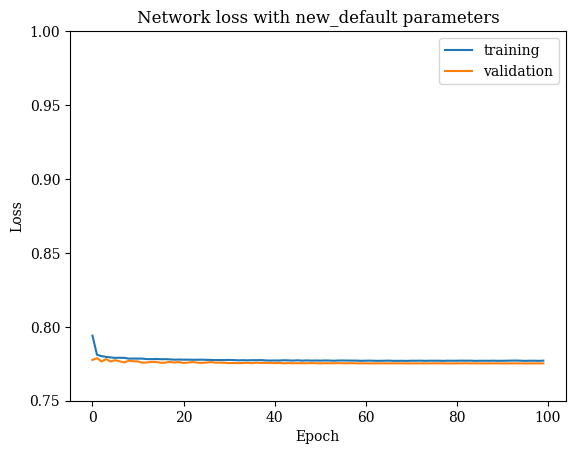

In [ ]:
title = 'new_default'

plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.title('Network loss with varying '+title+r' ($\theta$)')
plt.title('Network loss with new_default parameters')
for i in range(len(histories)):
    # if i == 1:
    #     continue

    _ = plt.plot(histories[i].history['loss'][:],label=r'training')#; $\theta$='+str(expt_value[i]))
    _ = plt.plot(histories[i].history['val_loss'][:],label=r'validation')#; $\theta$='+str(expt_value[i]))
    # save the history
    # np.save(path+'/network_tuning/'+title+'_'+str(expt_value[i])+'.npy',histories[0].history)
    # np.save(path+'/network_tuning/'+title+'.npy',histories[0].history)
plt.legend()
plt.ylim(0.75,1)
# plt.xlim(0,90)
# plt.savefig(path+'/network_tuning/'+title, dpi=250)


Metric data can be loaded from the numpy file as below

In [ ]:
# note the .item() is important
data = np.load(path+'/network_tuning/batch_size_100.npy',allow_pickle=True).item()
data['val_accuracy'][-1]

0.7307199835777283

## Network Output
The network estimates log K values for the test data.

In [ ]:
# collect network outputs f(xO).
validation_prediction = (model_instances_model[0].predict(x_test_scaled))
for i in range(n_models-1):
  temp = (model_instances_model[i+1].predict(x_test_scaled))
  validation_prediction = np.append(validation_prediction, temp, axis=1)


In [ ]:
# calucate mean average output
validation_prediction_avg = np.mean(validation_prediction, axis=1)
print(validation_prediction)
print(validation_prediction_avg)

In [ ]:
# network output f(xO).
validation_prediction = (model_instances_model[-1].predict(x_test_scaled))

print(validation_prediction)

[[ 1.7098885 ]
 [ 0.6808052 ]
 [-2.7790089 ]
 ...
 [ 0.98168206]
 [ 1.8154861 ]
 [ 1.2350124 ]]


# Coverage tests
Here I've tried to recreate the coverage tests using my own code. First we calculate p(M1|x). We then bin the posterior probabilities and examine the fraction of model 1 labels (SIMBA) in each bin.

In [ ]:
# calculate posteriors from network log K values
posterior_model_prob = np.exp(validation_prediction)/(1+np.exp(validation_prediction)) # p(M1|x)

print(posterior_model_prob.shape)

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)


(380563, 1)


In [ ]:
def coverage_test(post_model_prob, prob_array):
  '''
  Performs the coverage tests to evaluate calibration of the network
  :param post_model_prob: array of p(M1|x) predicted by network
  :param prob_array: array of chosen bins for posteriors
  :returns: posterior bin centres, validation fractions, post_bin_n (number of data prob in each bin),
            binomial_std (standard error of binomial)
  '''

  # perform coverage test
  bin_centres, fractions, post_bin_n = [],[],[]

  for i in range(0,len(prob_array)-1):
    # bin posteriors
    indexes = np.where((post_model_prob > prob_array[i])
                                        & (post_model_prob < prob_array[i+1]))[0]
    post_bin = post_model_prob[indexes]
    post_bin_mid = float((prob_array[i]+prob_array[i+1]) / 2)
    post_bin_size = float(len(post_bin))

    # get fraction of model 1 labels in each bin
    label_bin = y_test[indexes]
    fraction = np.sum(label_bin) / len(label_bin)

    bin_centres.append(post_bin_mid), fractions.append(fraction), post_bin_n.append(post_bin_size)


  # get the binomial error for each bin
  binomial_std = np.sqrt((np.asarray(bin_centres)*(1.-np.asarray(bin_centres))) / np.asarray(post_bin_n))

  return bin_centres, fractions, post_bin_n, binomial_std

In [ ]:
bin_centres, fractions, post_bin_n, binomial_std = coverage_test(posterior_model_prob, probability_array)

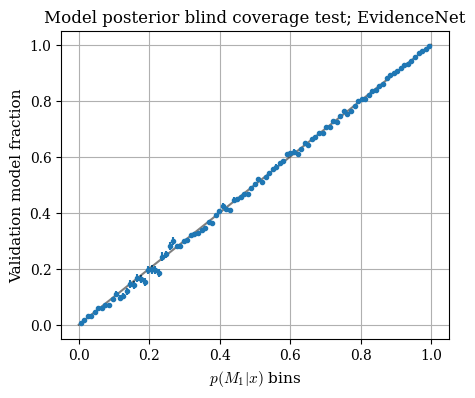

In [ ]:
plt.figure(figsize=(5,4))

# plt.plot(bin_centres, fractions,'.')
# plt.plot(post_bin_means, fractions,'.')
plt.errorbar(bin_centres, fractions, np.asarray(binomial_std), marker='.', ls='')
plt.title('Model posterior blind coverage test; EvidenceNet')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

# plt.savefig(path+'/coverage_test_unobservables_EvidenceNet.png', dpi=250)
# plt.axis('equal')

## Residual between model fraction and posterior probability from evidence network

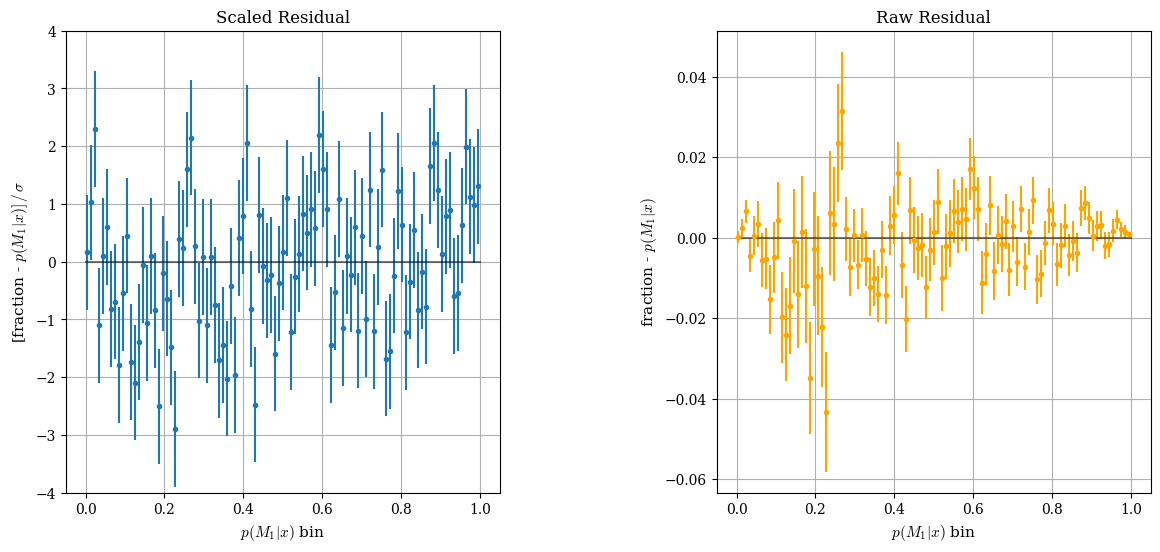

In [ ]:
residual = (np.asarray(fractions) - np.asarray(bin_centres))
scaled_residual = residual/np.asarray(binomial_std)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, scaled_residual,yerr=binomial_std/np.asarray(binomial_std), marker='.', ls='')
# plt.plot(post_bin_means, residual*binomial_std, marker='.', ls='',c='orange')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] \, / \, \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)
plt.ylim(-4,4)

plt.subplot(1,2,2)
# plt.plot(post_bin_means, residual, marker='.', ls='')
plt.errorbar(bin_centres, residual,yerr=binomial_std, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'fraction - $p(M_1 | x)  $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)

# plt.savefig(path+'/residuals_unobservables_EvidenceNet.png', dpi=250)


In [ ]:
print(np.mean(scaled_residual))
print(np.std(scaled_residual))

-0.09376741345530194
1.1684781999919132


## Normalising flows
The following cells use the package PZ Flow to learn the probability density function of the data. We train the neural density estimator to estimate p(x|M1) and p(x|M0), then derive the Bayes factor from this.

In [ ]:
# turn datasets into pandas dataframe for PZ Flow.
train_df = pd.DataFrame({'stellar_mass': x_train_scaled[:,0], 'stellar_metallicity': x_train_scaled[:,1], 'model': y_train})
val_df = pd.DataFrame({'stellar_mass': x_val_scaled[:,0], 'stellar_metallicity': x_val_scaled[:,1], 'model': y_val})
test_df = pd.DataFrame({'stellar_mass': x_test_scaled[:,0], 'stellar_metallicity': x_test_scaled[:,1], 'model': y_test})

# separate training and validation by model.
train_M1_df = train_df[train_df['model'] == 1]
train_M0_df = train_df[train_df['model'] == 0]
val_M1_df = val_df[val_df['model'] == 1]
val_M0_df = val_df[val_df['model'] == 0]




In [ ]:
# train the normalising flow.
flow_M1 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M1, val_loss_M1 = flow_M1.train(train_M1_df, val_M1_df, verbose=True, progress_bar=True)


Training 100 epochs 
Loss:
(0) -1.3031  -1.3065


  1%|          | 1/100 [00:31<52:44, 31.96s/it]

(1) -4.2613  -4.2616


  6%|▌         | 6/100 [02:02<29:39, 18.94s/it]

(6) -4.2846  -4.2847


 11%|█         | 11/100 [03:32<26:40, 17.99s/it]

(11) -4.2886  -4.2883


 16%|█▌        | 16/100 [05:00<24:52, 17.77s/it]

(16) -4.2866  -4.2870


 21%|██        | 21/100 [06:28<23:14, 17.65s/it]

(21) -4.2914  -4.2915


 26%|██▌       | 26/100 [07:57<21:54, 17.77s/it]

(26) -4.2910  -4.2912


 31%|███       | 31/100 [09:26<20:23, 17.74s/it]

(31) -4.2910  -4.2912


 36%|███▌      | 36/100 [10:53<18:39, 17.49s/it]

(36) -4.2913  -4.2915


 41%|████      | 41/100 [12:21<17:16, 17.56s/it]

(41) -4.2926  -4.2926


 46%|████▌     | 46/100 [13:49<15:46, 17.53s/it]

(46) -4.2931  -4.2933


 51%|█████     | 51/100 [15:17<14:23, 17.62s/it]

(51) -4.2850  -4.2844


 56%|█████▌    | 56/100 [16:45<12:58, 17.70s/it]

(56) -4.2907  -4.2911


 61%|██████    | 61/100 [18:14<11:26, 17.59s/it]

(61) -4.2933  -4.2933


 66%|██████▌   | 66/100 [19:42<09:59, 17.62s/it]

(66) -4.2918  -4.2917


 71%|███████   | 71/100 [21:10<08:30, 17.60s/it]

(71) -4.2939  -4.2940


 76%|███████▌  | 76/100 [22:38<07:04, 17.70s/it]

(76) -4.2923  -4.2926


 81%|████████  | 81/100 [24:06<05:34, 17.59s/it]

(81) -4.2923  -4.2922


 86%|████████▌ | 86/100 [25:35<04:07, 17.68s/it]

(86) -4.2940  -4.2941


 91%|█████████ | 91/100 [27:03<02:39, 17.76s/it]

(91) -4.2941  -4.2938


 96%|█████████▌| 96/100 [28:31<01:10, 17.66s/it]

(96) -4.2928  -4.2929


100%|██████████| 100/100 [29:42<00:00, 17.82s/it]

(100) -4.2930  -4.2929


In [ ]:
flow_M0 = Flow(["stellar_mass", 'stellar_metallicity'])

train_loss_M0, val_loss_M0 = flow_M0.train(train_M0_df, val_M0_df, verbose=True,  progress_bar=True)

Training 100 epochs 
Loss:
(0) -0.7498  -0.7500


  1%|          | 1/100 [00:23<38:49, 23.53s/it]

(1) -4.0105  -4.0152


  6%|▌         | 6/100 [01:23<19:01, 12.14s/it]

(6) -4.0381  -4.0416


 11%|█         | 11/100 [02:20<17:23, 11.73s/it]

(11) -4.0431  -4.0461


 16%|█▌        | 16/100 [03:15<16:04, 11.48s/it]

(16) -4.0406  -4.0442


 21%|██        | 21/100 [04:09<14:45, 11.21s/it]

(21) -4.0411  -4.0444


 26%|██▌       | 26/100 [05:03<13:40, 11.08s/it]

(26) -4.0491  -4.0525


 31%|███       | 31/100 [05:58<13:00, 11.32s/it]

(31) -4.0477  -4.0510


 36%|███▌      | 36/100 [06:56<11:59, 11.24s/it]

(36) -4.0467  -4.0503


 41%|████      | 41/100 [07:51<10:41, 10.87s/it]

(41) -4.0447  -4.0478


 46%|████▌     | 46/100 [08:45<09:35, 10.67s/it]

(46) -4.0492  -4.0522


 51%|█████     | 51/100 [09:40<08:34, 10.50s/it]

(51) -4.0488  -4.0519


 56%|█████▌    | 56/100 [10:41<08:32, 11.66s/it]

(56) -4.0453  -4.0486


 61%|██████    | 61/100 [11:41<08:03, 12.40s/it]

(61) -4.0458  -4.0486


 66%|██████▌   | 66/100 [12:35<06:19, 11.15s/it]

(66) -4.0487  -4.0515


 67%|██████▋   | 67/100 [12:56<06:22, 11.59s/it]

Training stopping after epoch 68 because training loss diverged.


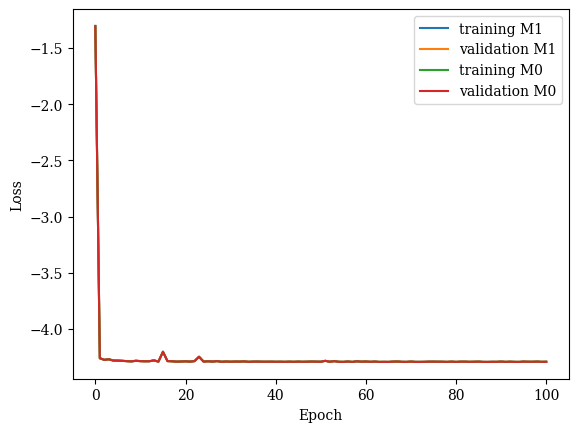

In [ ]:
plt.plot(train_loss_M1, label='training M1')
plt.plot(val_loss_M1, label='validation M1')
plt.plot(train_loss_M1, label='training M0')
plt.plot(val_loss_M1, label='validation M0')
# plt.ylim(-5,-4)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Flow Output
The following cells output the learnt densities for each model and plots them next to the original binned data.

In [ ]:
def density(flow, xlim=(0.4,0.7), ylim=(0.4,0.7) ):
  '''
  Calculates a grid of density values
  '''

  nx, ny = (1000, 1000)
  x, y = np.linspace(xlim[0], xlim[1], nx), np.linspace(ylim[0], ylim[1], ny)
  # y = np.linspace(ylim[0], ylim[1], ny)
  xv, yv = np.meshgrid(x, y)
  X, Y = xv.flatten(), yv.flatten()
  # Y = yv.flatten()
  grid_df = pd.DataFrame({'stellar_mass': X, 'stellar_metallicity': Y})
  density = np.exp(flow.log_prob(grid_df))
  density = density.reshape((nx,ny))
  # matrix needs flipping.
  density = np.flipud(density)

  return density





In [ ]:
# define grid limits for densities.
xx, yy = (0.4,0.65), (0.4,0.65)
dens_M1 = density(flow_M1, xx,yy)
dens_M0 = density(flow_M0, xx,yy)

[Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)'),
 Text(0.5, 0, 'stellar mass (scaled)'),
 Text(0, 0.5, 'stellar metallicity (scaled)')]

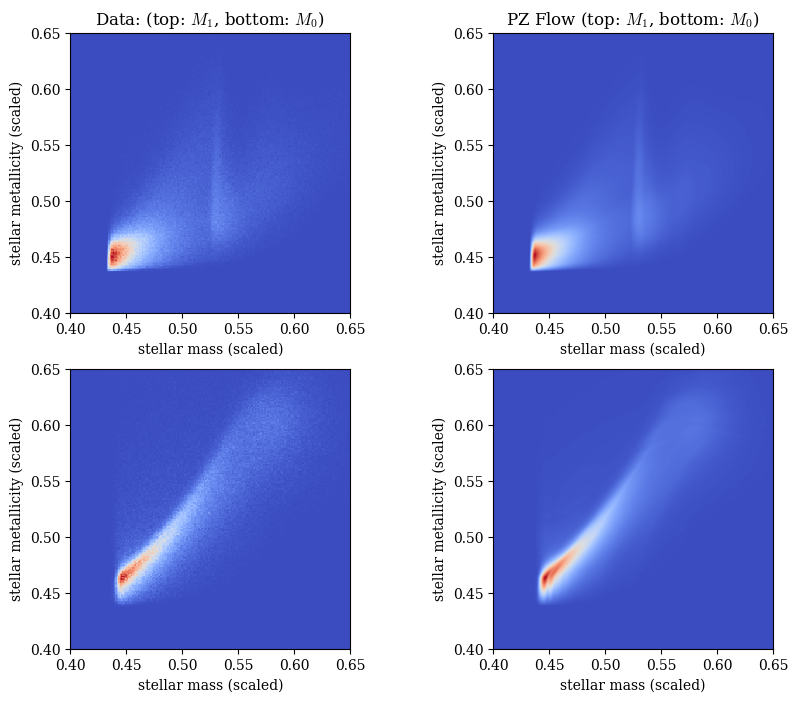

In [ ]:
# plot outputs.
fig, ax = plt.subplots(2,2,  figsize=(10,8))

ax[0,0].set_title('Data: (top: $M_1$, bottom: $M_0$)')
ax[0,0].hist2d(train_M1_df.iloc[:,0],train_M1_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[1,0].hist2d(train_M0_df.iloc[:,0],train_M0_df.iloc[:,1], bins=[np.linspace(xx[0],xx[1],200), np.linspace(yy[0],yy[1],200)])
ax[0,0].axis('square')
ax[1,0].axis('square')


ax[0,1].set_title('PZ Flow (top: $M_1$, bottom: $M_0$)')
ax[0,1].imshow(dens_M1,extent=[xx[0],xx[1],yy[0],yy[1]])
ax[1,1].imshow(dens_M0,extent=[xx[0],xx[1],yy[0],yy[1]])


plt.setp(ax, xlabel='stellar mass (scaled)' , ylabel='stellar metallicity (scaled)')

In [ ]:
logprob_M1 = flow_M1.log_prob(test_df) # log[p(x|M1)]
logprob_M0 = flow_M0.log_prob(test_df)




In [ ]:
# idx = np.where(logprob_M1 > -1e10)
# logprob_M1 = logprob_M1[idx]
# logprob_M0 = logprob_M0[idx]

The flow outputs log( p(x|M1) ) and log( p(x|M0) ). We combine these to get log K. Note that logK_flow includes the priors ratio correction in order to perform the coverage tests so is not technically logK. This correction is appplied in the cell below.

In [ ]:
# include priors ratio correction to compare output of EvidenceNet and PZFlow.
logK_flow = logprob_M1 -  logprob_M0 + np.log(M_ratio(y_test))



Calculate the Bayes factors and perform a coverage test.

0.83046633 2.0270646


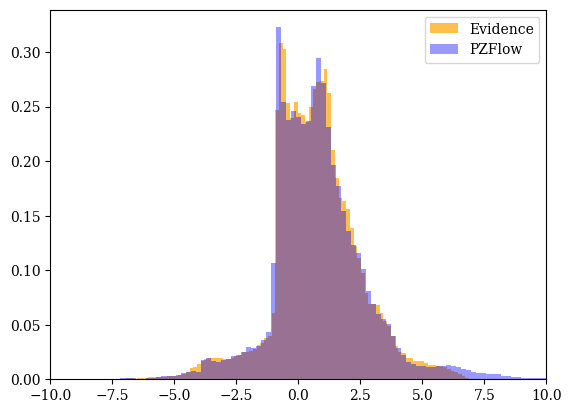

In [ ]:
print(np.mean(logK_flow), np.std(logK_flow))
plt.hist(validation_prediction,bins=100,density=True, alpha=0.7, color='orange', label='Evidence')
plt.hist(logK_flow,bins=np.linspace(-10,10,100),density=True, alpha=0.4,color='blue', label='PZFlow')

plt.xlim(-10,10)
plt.legend()

In [ ]:
# get p(M1|x) from logK
post_flow = np.exp(logK_flow)/(1+np.exp(logK_flow))

# prepare posterior bins
nbins = 100
probability_array  = np.linspace(0,1,nbins)
# print(probability_array )

In [ ]:
bin_centres_flow, fractions_flow, post_bin_n_flow, binomial_std_flow = coverage_test(post_flow, probability_array)

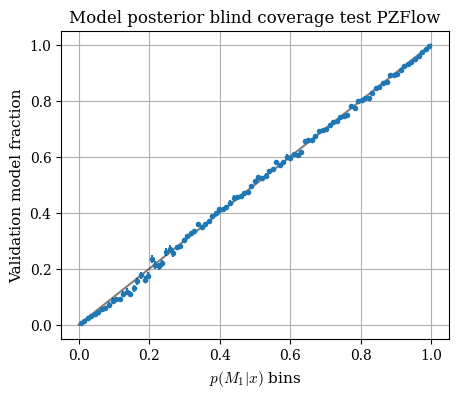

In [ ]:
plt.figure(figsize=(5,4))

plt.errorbar(bin_centres_flow, fractions_flow, np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Model posterior blind coverage test PZFlow')
plt.xlabel(r'$p(M_1 | x)$ bins', fontsize=11)
plt.ylabel(str('Validation model fraction'), fontsize=11)
plt.plot([0,1],[0,1],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

# plt.savefig(path+'coverage_test_20_B.png', dpi=250)
# plt.axis('equal')

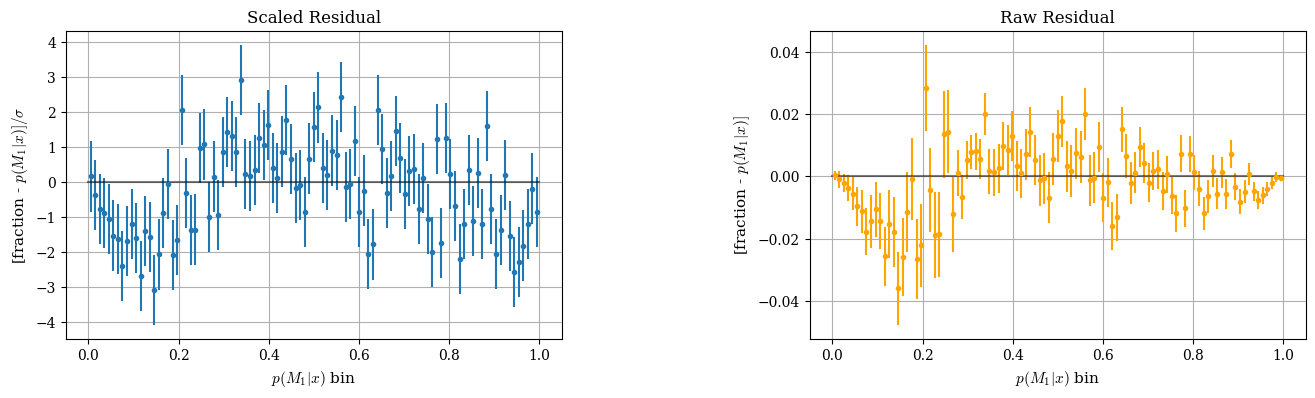

In [ ]:
residual_flow = (np.asarray(fractions_flow) - np.asarray(bin_centres_flow))
scaled_residual_flow = residual_flow/np.asarray(binomial_std_flow)

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.errorbar(bin_centres_flow, scaled_residual_flow,yerr=binomial_std_flow/np.asarray(binomial_std_flow), marker='.', ls='')
plt.title('Scaled Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] / \sigma$', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(bin_centres_flow, residual_flow,yerr=binomial_std_flow, marker='.', ls='',c='orange')
plt.title('Raw Residual')
plt.xlabel(r'$p(M_1 | x)$ bin', fontsize=11)
plt.ylabel(r'[fraction - $p(M_1 | x) ] $', fontsize=11)
plt.plot([0,1],[0,0],'k-',alpha=0.5)
# plt.axis('square')
plt.grid(True)

plt.subplots_adjust(wspace=.5)


In [ ]:
print(np.mean(scaled_residual_flow))
print(np.std(scaled_residual_flow))

-0.2611401387111573
1.2960312164134398
